이번 대회는 주어진 긍정 및 부정 리뷰 데이터를 통해 test 데이터의 긍/부정 라벨을 분류하는 대회입니다.

target은 label 컬럼이며 0(부정), 1(긍정) 값으로 이루어져 있습니다.

대회를 시작하기 앞서 어떤 데이터가 주어졌고 어떤 방식으로 활용할 수 있을지

데이터를 분석하고 시각화하며 인사이트를 얻어내는 작업이 필요합니다.

### 패키지 설치

EDA를 시작하기에 앞서 필요한 패키지 설치

In [31]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install konlpy
# !pip install collections
# !pip install wordcloud
# !pip install sys

데이터 불러오기

In [32]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import sys
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud

# 다운받은 csv를 pandas의 DataFrame 형식으로 불러옵니다.
data = pd.read_csv('dataset/train.csv')

data # 데이터를 확인합니다.

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0
...,...,...,...
4995,4996,좋은 배우들로 3류영화를 찍은 안타까운 영화,0
4996,4997,진짜 드럽게 재미없다 에드워드 호퍼 그림에 배경 빼고는 볼게 아닌영화,0
4997,4998,가장 실망스러운 영화.. 지금까지 본영화중..,0
4998,4999,"이런 평점 테러, 네이버에서 좀 막아야 하는 것 아닌가?",1


In [33]:
for i, col in enumerate(data.columns):
    print(i, col)

0 id
1 document
2 label


데이터를 살펴보니 한글로 된 문자열이 주를 이루며, 각 리뷰는 긍정 리뷰는 1 , 부정 리뷰는 0으로 라벨링 되어있다.

### 결측치 확인

결측치( NA : Not Available ) 란 값이 누락된 데이터를 말한다.

보다 정확한 분석을 하기 위해서는 데이터의 결측치를 확인하고, 적절히 처리해주어야 한다.

어떤 데이터에 결측치가 있나 확인해보자.

In [34]:
# 결측치 존재 여부를 확인해주는 함수
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna()) # NA값( 결측치 ) 가 있으면 True( 1 ) 더함 , 없으면 False( 0 ) 더하여 저장 ( 정수형 )
        is_missing = True if missing_values >= 1 else False # NA가 한번이라도 있었으면 True , 아니면 False
        if is_missing: # 루프 문 도는 중에 한번이라도 결측치가 있었으면 실행됨
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0: # 루프문 도는 중에 한번이라도 결측치가 있었으면 처음 발생한 이후 다시는 실행되지 않음
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(data)

결측치가 존재하지 않습니다


결측치가 존재하지 않는 깔끔한 데이터셋이였다. 넘어가도록 하자.

### 기초 통계 분석

In [35]:
# 데이터 살펴보기
data.info() # null( NA값 ) 아닌 값이 count 된 수 = Non-Null Count : 여기에서는 모두 null값 아니므로 5000번 전부 count 된다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   int64 
 1   document  5000 non-null   object
 2   label     5000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 117.3+ KB


info() 함수를 이용해 간단하게 데이터셋 살펴 보았다. 

보아하니 크게 중요하지 않은 id 열을 제외하면 object형 'document'와 , int형 'label' 총 두개의 컬럼으로 이루어져 있다.

리뷰 내용에 해당하는 'document' 변수를 집중적으로 살펴보아야 할 것이다.

### 긍정 / 부정 리뷰 확인

긍정 및 부정 리뷰 각각의 개수를 확인해 보겠다.

In [36]:
val_count = data['label'].value_counts() # 유니크값의 개수 확인 , 하나의 딕셔너리처럼 key 로 접근
print("라벨 0인 리뷰 개수 : ", val_count[0])
print("라벨 1인 리뷰 개수 : ", val_count[1])
# print("라벨 2인 리뷰 개수 : ", val_count[2]) - 에러 뜸 : 아예 값이 없기 때문에 ->  딕셔너리처럼 일단 value가 있어야 세어지나봄

라벨 0인 리뷰 개수 :  2564
라벨 1인 리뷰 개수 :  2436


데이터 시각화

그래프 시각화에 필요한 패키지를 불러온다.

In [37]:
import matplotlib.pyplot as plt # 그래프 그래기 위한 패키지
%matplotlib inline
plt.style.use("ggplot")

plot 함수를 이용해 라벨 개수를 그래프로 그려 시각적으로 비교해보았다.

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


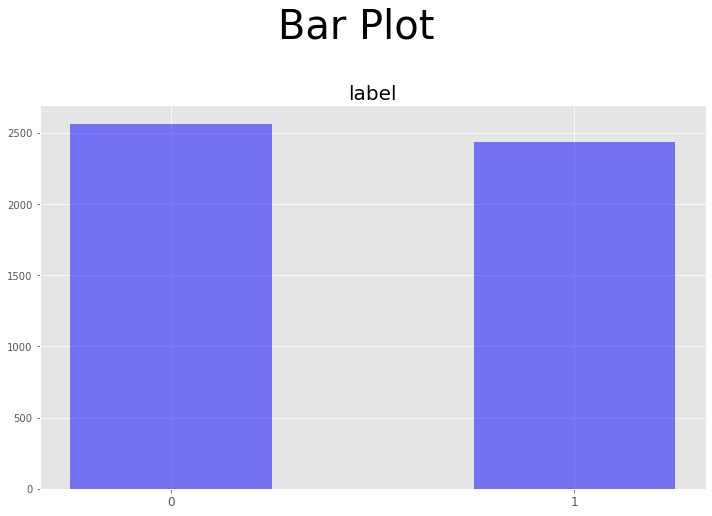

In [38]:
# 히스토그램 사용해서 데이터의 분포를 살펴보겠다.
feature = data['label']

plt.figure(figsize=(10,7.5)) # 그래프 이미지 크기 설정
plt.suptitle("Bar Plot", fontsize = 40) # 부제목과 폰트 크기 설정

plt.title("label", fontsize = 20) # 제목과 폰트 크기 설정
temp = feature.value_counts() # feature 변수의 변수별 개수 계산
plt.bar(temp.keys(), temp.values, width = 0.5, color = "b", alpha = 0.5) # 막대그래프 생성
plt.xticks(temp.keys(), fontsize = 12) # x축 값, 폰트 크기 설정
plt.tight_layout(rect = [0, 0.03, 1, 0.95]) # 레이아웃 설정
plt.show() # 그래프 나타내기

두 라벨의 분포가 비슷한 것을 확인할 수 있다.

### 리뷰 길이 확인

In [39]:
str_len_mean = np.mean(data['document'].str.len()) # 리뷰 길이의 평균값 계산
print("리뷰의 길이 : ", str_len_mean)

리뷰의 길이 :  27.1352


리뷰 문자열의 평균 길이는 약 27 이다.

이번에는 리뷰들의 문자열 길이를 히스토그램으로 나타내보겠다.

### 전체리뷰 / 긍정리뷰 / 부정리뷰 비교

In [40]:
# 데이터 필터링을 위한 마스크 설정
mask_pos = (data.label == 1)
mask_neg = (data.label == 0)

# 전체 / 긍정 / 부정 리뷰 집합을 설정한다.
df_train = data.document.copy() # 전체 train 데이터
df_pos = data.loc[mask_pos,:].document # 긍정 리뷰에만 해당하는 train 데이터
df_neg = data.loc[mask_neg,:].document # 부정 리뷰에만 해당하는 train 데이터

# 세 집합을 리스트로 묶어준다.
compare = [df_train, df_pos, df_neg]

긍정 / 부정 데이터셋이 잘 분리되었는지 확인한다.

In [41]:
df_pos.head() # 긍정 데이터 확인하기

1            히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...
2    괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~
5       내인생에 있어 손까락에 꼽히는 영화 원작을 능가한 리메이크작
7          마음이 성숙하고 보면 다르게 보이는 영화.. 걸작이다.
8                   가슴 찡했던, 오래 기억에남을 영화!!
Name: document, dtype: object

In [42]:
df_neg.head() # 부정 데이터 확인하기

0                  영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐
3                아무래도 20년도지난작품이라 지금보기는너무유치하다
4    지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.
6                성룡영화중 최악 .. 차라리 러시아워가 훨씬 나음
9                   결말 기분나쁘다 공포매니아에게 이따위 결말을
Name: document, dtype: object

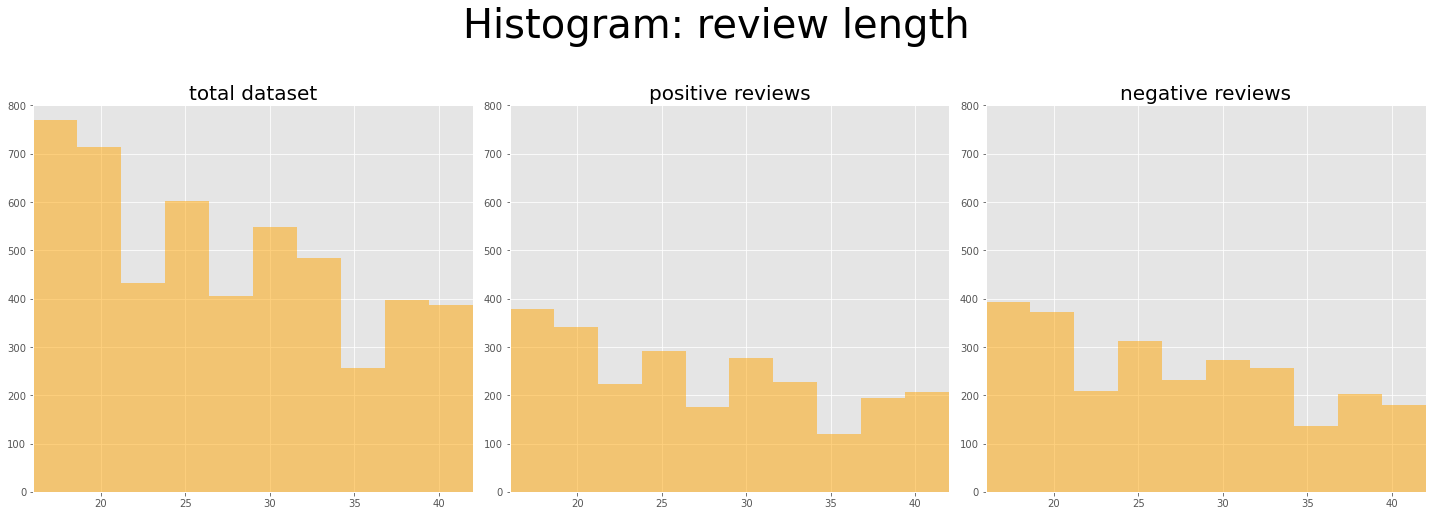

In [43]:
# 히스토그램을 사용해서 데이터의 분포를 살펴보자.
plt.figure(figsize=(20, 7.5))
plt.suptitle("Histogram: review length",fontsize=40)
name = ['total dataset', 'positive reviews', 'negative reviews'] # 제목으로 사용할 문자열

for i in range(len(compare)):
    document = compare[i]
    string_len = [len(x) for x in document]
    plt.subplot(1, 3, i + 1) # 행 개수 / 열 개수 / 해당 그래프 표시 순서
    plt.title(name[i], fontsize = 20)
    plt.axis([16, 42, 0, 800]) # x축 시작, 끝 / y축 시작, 끝
    plt.hist(string_len, alpha = 0.5, color="orange") # 히스토그램 생성, alpha : 그래프의 투명도 조절
    
plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

문자열 길이는 15 ~ 45 사이에 분포하며 대체적으로 길이가 짧아질 수록 빈도수가 더 높은 것을 확인할 수 있었다.

또한 긍정 / 부정 데이터에 상관없이 리뷰의 길이는 비슷한 분포를 보인다.

이번에는 띄어쓰기를 기준으로 각 리뷰당 포함하는 어절(word) 수를 살펴보겠다.

다음 예시와 같이 split() 함수 사용해 공백 기준으로 하여 어절 단위로 문자열을 분리하는 방법 사용

In [44]:
word_split = data['document'].str.split() # 공백을 기준으로 문자열 분리해준다.
word_split[:5] # 상위 5개 값 확인

0                     [영상이나, 음악이, 이쁘다, 해도, 미화시킨, 불륜일뿐]
1                 [히치콕이, 이, 영화를, 봤다면, 분명, 박수를, 쳤을듯...]
2       [괜찮은, 음악영화가, 또, 나왔군요!!!, 따뜻한, 겨울이, 될, 것, 같아요~]
3                      [아무래도, 20년도지난작품이라, 지금보기는너무유치하다]
4    [지금까지의, 영화들이, 그랬듯., 이, 영화역시, 일본에, 대한, 미화는, 여전하다.]
Name: document, dtype: object

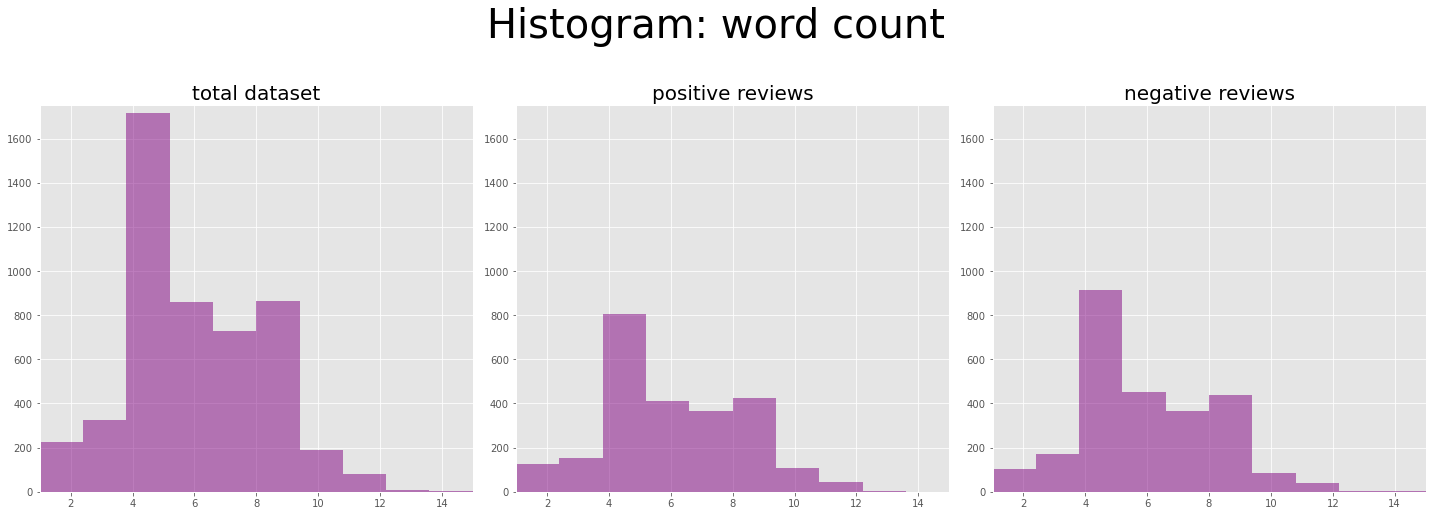

In [45]:
# 히스토그램 을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(20,7.5))
plt.suptitle("Histogram: word count", fontsize=40)
name = ['total dataset', 'positive reviews', 'negative reviews'] # 제목으로 사용할 문자열

for i in range(len(compare)):
    document = compare[i]
    split = document.str.split()
    split_len = [len(x) for x in split] 
    plt.subplot(1,3,i+1) # 행 개수/ 열 개수/ 해당 그래프 표시 순서
    plt.title(name[i], fontsize=20)
    plt.axis([1, 15, 0, 1750])  #x축 시작, 끝 / y축 시작, 끝
    plt.hist(split_len, alpha=0.5, color='purple')
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

4~6개의 어절로 이루어진 리뷰가 가장 많은 것을 확인했습니다. <hr>

분포는 마찬가지로 세 데이터셋이 거의 동일하군요.

# Word CLoud

### 워드 클라우드(word cloud)란?

태그 클라우드와 동의어인 워드 클라우드는 문서의 키워드 등을 직관적으로 파악할 수 있도록 하는 시각화 기법입니다.

예를 들어, 문서에 자주 언급된 단어일수록 크게 시각화하여 문서에서 등장하는 주요 단어들을 한눈에 파악할 수 있습니다.

이 기법은 문서 빅데이터 분석에서 자주 사용되곤 합니다.

### 기본 함수 정의

워드 클라우드를 생성하기 위한 패키지를 불러오고 기본 함수들을 정의합니다.

In [46]:
def df2str(df):
    #전체 리뷰들을 하나의 문자열로 만듦
    s = [s for s in df]
    document = ""
    for i in range(len(s)):
        document += s[i]
    return document

def get_noun(text):
    # okt tagger를 이용해 명사 추출
    okt = Okt()
    noun = okt.nouns(text)
    for i,v in enumerate(noun):
        if len(v)<2:
            noun.pop(i)
    count = Counter(noun)
    noun_list = count.most_common(100)

    return noun_list

def visualize(noun_list, title):
    # 워드클라우드 이미지 생성
    wc= WordCloud(
        font_path = './a고딕13.ttf',    # 한글폰트 경로 설정
        background_color='white',                             # 배경 색깔 정하기
        colormap = 'Dark2',                                # 폰트 색깔 정하기
        width = 800,
        height = 800).generate_from_frequencies(dict(noun_list)) 
    
    plt.figure(figsize=(10,10)) #이미지 사이즈 지정
    plt.suptitle("Word Cloud", fontsize=40)
    plt.title(title, fontsize=20)
    plt.imshow(wc, interpolation='lanczos') #이미지의 부드럽기 정도
    plt.axis('off') #x y 축 숫자 제거
    plt.show()  # 워드클라우드 이미지 확인
    
    return wc

### 전체 train 데이터 워드 클라우드 생성

In [47]:
document = df2str(df_train) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:5] # 상위 5개 단어 확인

[('영화', 1501), ('정말', 320), ('진짜', 269), ('최고', 220), ('평점', 185)]

C:\Users\com\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\com\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\com\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\com\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47568 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\com\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\com\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51676 missing from current font.

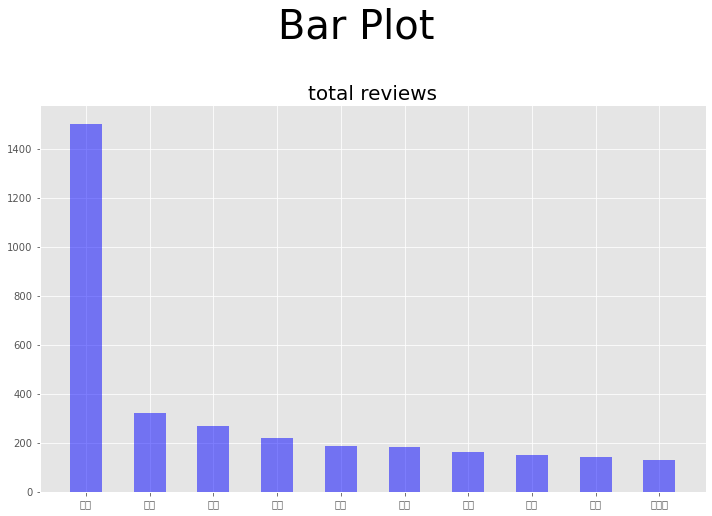

In [48]:
# 폰트 넣기 참고 링크 : 
#https://ehpub.co.kr/47-matplotlib%EC%9D%98-rc%EC%97%90-%ED%95%9C%EA%B8%80-%ED%8F%B0%ED%8A%B8%EB%A5%BC-%EC%84%A4%EC%A0%95%ED%95%A0-%EC%88%98-%EC%9E%88%EC%96%B4%EC%9A%94/
from matplotlib import font_manager,rc

# 현재 상태 : 관련 링크 보고 비슷하게 만들어도
# 히스토그램 아래의 x축 한글은 깨진다.


#폰트 경로
font_path = 'C:\\Users\\com\\Documents\\Jupyter\\NanumBarunGothic.ttf'
#폰트 이름 얻어오기
NanumBarunGothic = font_manager.FontProperties(fname=font_path).get_name()

plt.rc('font', family='NanumBarunGothic') 
top_10 = dict(noun_list[:10]) # 추출한 명사 중 상위 10개
plt.figure(figsize=(10,7.5))
plt.suptitle("Bar Plot", fontsize=40)
plt.title('total reviews', fontsize=20)
plt.bar(top_10.keys(), top_10.values(), width=0.5, color='b', alpha=0.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

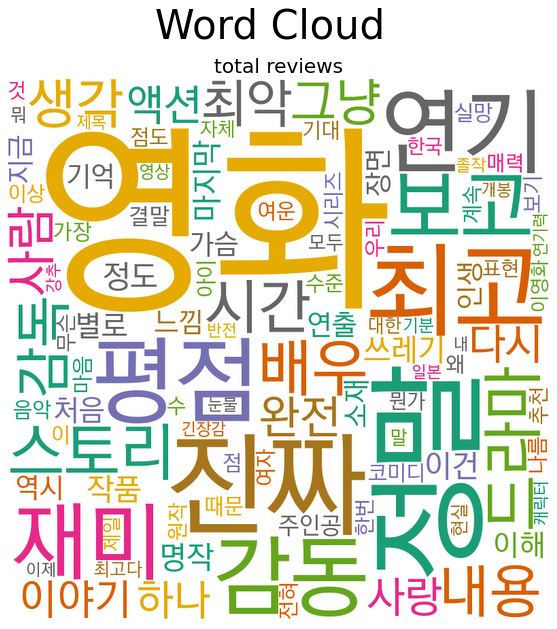

In [49]:
total_reviews = visualize(noun_list,'total reviews') # 워드클라우드 시각화

최고, 감동 등 긍정적인 키워드와 최악, 쓰레기 등 부정적인 키워드가 혼재함을 확인할 수 있었다.

이번에는 긍정, 부정 리뷰별 키워드를 각각 확인해 보겠다.

### 긍정 리뷰 워드클라우드 생성

긍정 리뷰만을 가지고 워드클라우드를 생성해 보겠다.

먼저 전체 긍정 리뷰를 하나의 문자열로 만든 뒤 명사 리스트를 만든다.

In [50]:
document_p = df2str(df_pos) # 긍정 리뷰 데이터프레임을 하나의 큰 문자열로 만듭니다.
noun_list_p = get_noun(document_p) # 명사만을 추출하고 빈도수를 계산합니다.
noun_list_p[:20] # 상위 20개 값 확인

[('영화', 757),
 ('정말', 216),
 ('최고', 214),
 ('진짜', 136),
 ('감동', 134),
 ('연기', 108),
 ('드라마', 89),
 ('보고', 88),
 ('사랑', 72),
 ('다시', 70),
 ('평점', 67),
 ('생각', 65),
 ('명작', 60),
 ('배우', 58),
 ('사람', 55),
 ('완전', 54),
 ('마지막', 52),
 ('가슴', 51),
 ('이야기', 50),
 ('재미', 48)]

긍정 리뷰의 상위 20개 키워드를 확인하였더니

최고, 감동, 사랑, 재미 등 긍정적인 감정을 드러내는 단어들이 보인다.

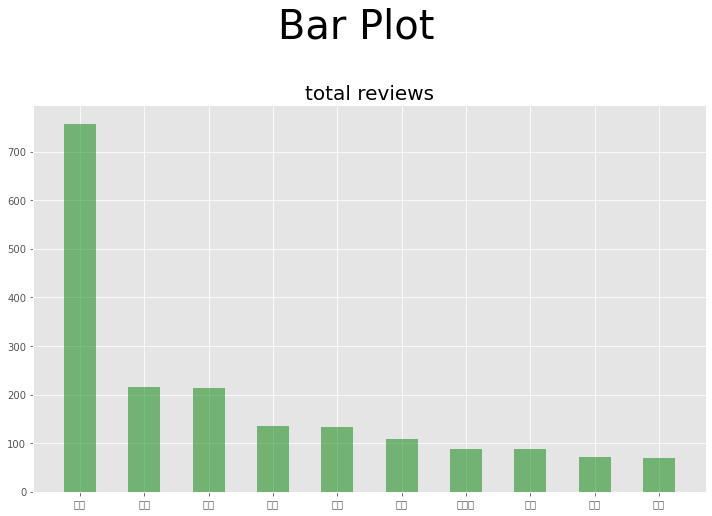

In [52]:
plt.rc('font', family='NanumBarunGothic') 
top_10 = dict(noun_list_p[:10])
plt.figure(figsize=(10,7.5))
plt.suptitle("Bar Plot", fontsize=40)
plt.title('total reviews', fontsize=20)
plt.bar(top_10.keys(), top_10.values(), width=0.5, color='green', alpha=0.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

긍정 리뷰 워드 클라우드를 생성한다.

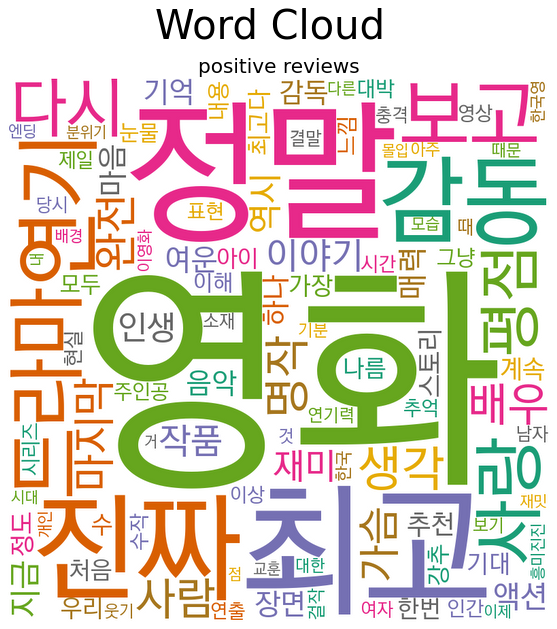

In [53]:
positive_reviews = visualize(noun_list_p, 'positive reviews') # 워드클라우드 시각화

최고, 감동, 사랑, 재미 등 긍정적인 감정을 드러내는 단어들이 보인다.

### 부정 리뷰

이번에는 부정 리뷰만을 가지고 워드클라우드를 실행해 보겠다.

먼저 전체 부정 리뷰를 하나의 문자열로 만든 뒤 명사 리스트를 만든다.

In [54]:
document_n = df2str(df_neg) # 부정 리뷰 데이터프레임을 하나의 큰 문자열로 만듭니다.
noun_list_n = get_noun(document_n) # 명사만을 추출하고 빈도수를 계산합니다.
noun_list_n[:20] # 상위 20개 값 확인

[('영화', 746),
 ('진짜', 132),
 ('평점', 118),
 ('재미', 104),
 ('정말', 104),
 ('스토리', 102),
 ('최악', 98),
 ('시간', 97),
 ('내용', 85),
 ('감독', 78),
 ('그냥', 75),
 ('연기', 72),
 ('쓰레기', 70),
 ('배우', 69),
 ('이건', 55),
 ('별로', 53),
 ('보고', 52),
 ('액션', 43),
 ('하나', 41),
 ('사람', 41)]

부정 리뷰의 상위 20개 키워드를 확인하였더니

대표적으로 최악, 쓰레기, 별로 등의 부정적인 감정을 드러내는 단어가 눈에 띈다.

C:\Users\com\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50501 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\com\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\com\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\com\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\com\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 46021 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\com\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 50501 missing from current font.

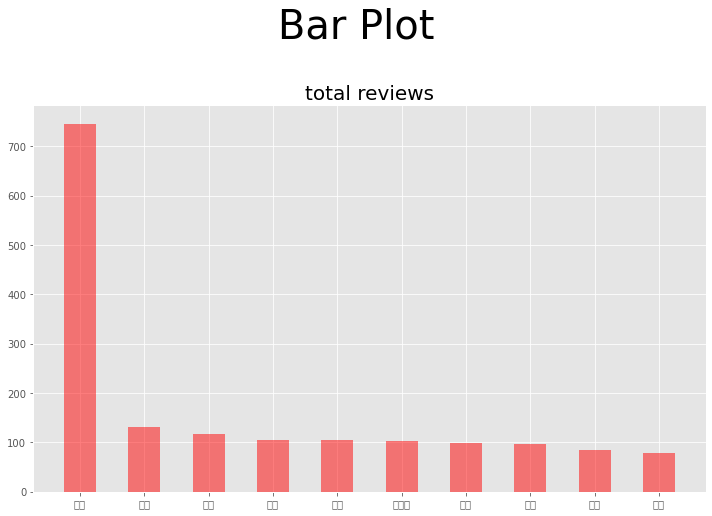

In [55]:
plt.rc('font', family=NanumBarunGothic) 
top_10 = dict(noun_list_n[:10])
plt.figure(figsize=(10,7.5))
plt.suptitle("Bar Plot", fontsize=40)
plt.title('total reviews', fontsize=20)
plt.bar(top_10.keys(), top_10.values(), width=0.5, color='r', alpha=0.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

다시 부정 리뷰 워드클라우드를 그려보겠다.

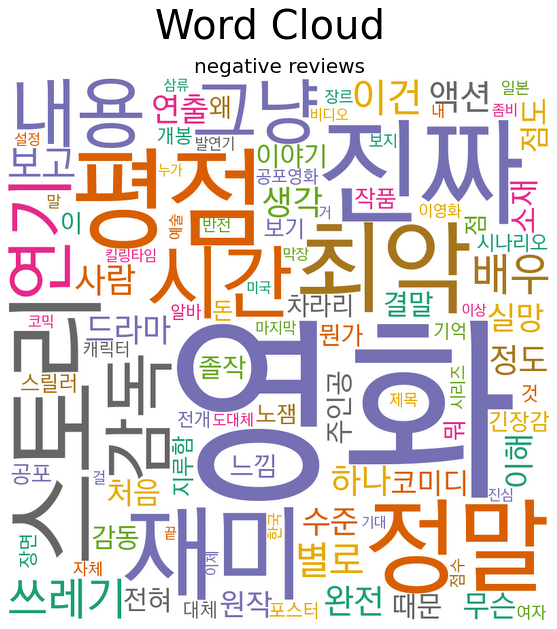

In [56]:
negative_reviews = visualize(noun_list_n, 'negative reviews') # 워드클라우드 시각화

# 중복 단어 제거하기

위 워드클라우드를 보면 '영화', '진짜', '정말' 등과 같이 긍정/부정 리뷰 모두 등장하는 단어들이 존재한다.

이러한 문제를 해결하기 위해 긍정, 부정 리뷰에 공통적으로 등장하는 단어들을 제거한 뒤 다시 시각화하겠다.

In [57]:
print("부정 리뷰 Top10:", noun_list_n[:10])
print("긍정 리뷰 Top10:", noun_list_p[:10])

부정 리뷰 Top10: [('영화', 746), ('진짜', 132), ('평점', 118), ('재미', 104), ('정말', 104), ('스토리', 102), ('최악', 98), ('시간', 97), ('내용', 85), ('감독', 78)]
긍정 리뷰 Top10: [('영화', 757), ('정말', 216), ('최고', 214), ('진짜', 136), ('감동', 134), ('연기', 108), ('드라마', 89), ('보고', 88), ('사랑', 72), ('다시', 70)]


위와 같이 공통 단어들이 많이 등장한다.

따라서 긍정 리뷰와 부정 리뷰 모두 자주 등장하는 단어들을 골라내보겠다.

In [58]:
neg = list(dict(noun_list_n).keys()) # key(명사) 만을 이용해 리스트 생성
pos = list(dict(noun_list_p).keys())

drop_words = [x for x in neg if x in pos] # 부정리뷰에 포함된 명사가 긍정리뷰에도 등장할 경우 drop_words라는 리스트에 저장
print("공통으로 등장하는 단어들 Top10\n",drop_words[:10])

공통으로 등장하는 단어들 Top10
 ['영화', '진짜', '평점', '재미', '정말', '스토리', '시간', '내용', '감독', '그냥']


과정이 잘 이루어졌다!!!

다음으로 해당 단어들을 각각 단어 리스트에서 제거하겠다.

In [59]:
noun_list_n_filter = [x for x in noun_list_n if x[0] not in drop_words]
noun_list_p_filter = [x for x in noun_list_p if x[0] not in drop_words]

In [62]:
print("정제된 부정 리뷰 상위 단어 Top10\n",noun_list_n_filter[:10])

정제된 부정 리뷰 상위 단어 Top10
 [('최악', 98), ('쓰레기', 70), ('이건', 55), ('별로', 53), ('실망', 36), ('수준', 36), ('점도', 34), ('원작', 31), ('무슨', 31), ('코미디', 29)]


마지막으로 정제된 두 단어 리스트들을 워드클라우드로 시각화해보겠다.

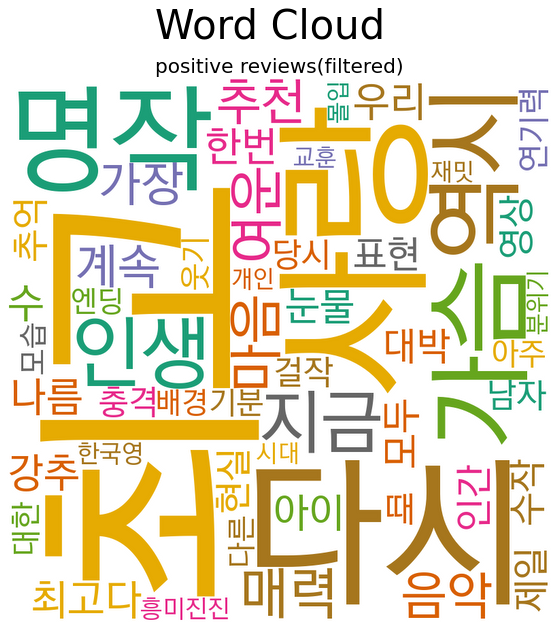

In [63]:
positive_reviews_filtered = visualize(noun_list_p_filter, 'positive reviews(filtered)') # 워드클라우드 시각화

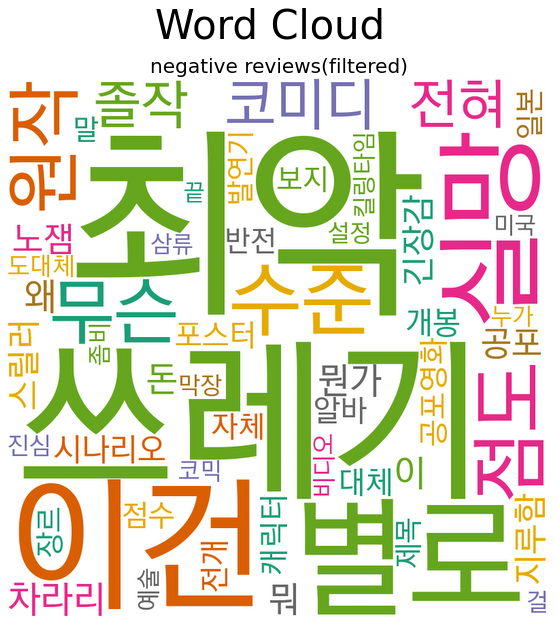

In [64]:
negative_reviews_filtered = visualize(noun_list_n_filter, 'negative reviews(filtered)') # 워드클라우드 시각화

긍/부정 라벨에 따라 등장하는 단어가 카테고리에 잘 분리되었습니다!
# 끝